# Databehandlingsdel og modellering 

Her er en kort interaktiv innføring i programmene vi har brukt i prosjektet vårt. Noen forkortelser å legge merke til:

| Jordtype | forkortelse | varmt | ute |
| --- | --- | --- | --- |
| **Svært god jord** | SGJ | VSGJ | USGJ |
| **Mindre god jord** | MGJ | VMGJ | UMGJ |

PS!: For at en celle skal kjøres, må de tidligere cellene også kjøres. 
### Kalibrering 
Vi kalibrerte sensorene siden de hadde avvikende målinger i det samme omgivelsen. Ved å anta at en velventilert rom har en $CO_2$ ppm på 1000 og rh på 40, kunne vi justere alle datapunktene slik at de starter riktig. Med andre ord antar vi at endringen er rkigtig, men det er bare utgangspunktet som er avikende. 

In [2]:
def calibrate(data):
    time, co2, temp, rh = data
    co2_calibration_number =  1000 - float(co2[0])
    rh_calibration_number = 40 - float(rh[0])
    co2 = [float(value) + co2_calibration_number for value in co2]
    rh = [float(value) + rh_calibration_number for value in rh]
    return time, co2, temp, rh

### Koden som kjøres i micro:bit (micropython)

```python
# Write your code here :-)
#Importerer nødvendige bibliotek
from microbit import *
import time

#Definerer variabler
co2 = 0
tempC = 0
rh = 0

samplerate = 25000 #time between samples (ms)
valueline = ''
samplefile = ''
n = 0

#Definerer funksjoner vi skal bruke i programmet
def check_incoming_messages():
    global co2, tempC, rh
    if uart.any():
        response = str(uart.read(), 'UTF-8')
        if len(response) < 8:
            return
        cmd_letter = response[1]
        cmd_value_str = response[2:8]
        value = int(cmd_value_str)
        if cmd_letter == 'Z':
            co2 = value
        elif cmd_letter == 'T':
            tempC = (value - 1000) / 10.0
        elif cmd_letter == 'H':
            rh = value / 10

def get_co2():
    uart.write('Z\r\n')
    sleep(100)
    check_incoming_messages()
    return co2

def get_tempC():
    uart.write('T\r\n')
    sleep(100)
    check_incoming_messages()
    return tempC

def get_rh():
    uart.write('H\r\n')
    sleep(100)
    check_incoming_messages()
    return rh

#Programmet som blir kjørt på micro:bit
while True:
    display.show(Image.HAPPY)
    if button_a.is_pressed(): # Button A starts datalogging
        display.show(Image.DIAMOND)
        uart.init(tx=pin0, rx=pin1)  #Initialiserer kommunikasjon med sensor.
        n = 0
        while not button_b.is_pressed() and n < 110: # Stopp logging before memory gets full or button B pressed.
            sleep(samplerate)
            valueline = str(time.ticks_ms()/1000) + ';' + str(get_co2())+ ';' + str(get_tempC()) + ';' + str(get_rh())  + '\r\n'
            samplefile = samplefile + valueline
            n = n + 1
        uart.init(115200)  #Initialiserer kommunikasjon med PC.
        with open('data.txt', 'w') as my_file:
            my_file.write(samplefile)
        display.show(Image.ASLEEP)
        sleep(3000)


### Importer

In [15]:
import matplotlib.pyplot as plt
import numpy as np 
from data_handler import data_extract
from kalibrering import calibrate
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
%matplotlib inline

### Leser av nødvendig data

In [12]:
data_vsgj = data_extract("raw_data/vsgj.txt")
data_usgj = data_extract("raw_data/usgj.txt")
data_vmgj = data_extract("raw_data/vmgj.txt")
data_umgj = data_extract("raw_data/umgj.txt")

tid_vsgj , co2_vsgj, temp_vsgj, rh_vsgj   = calibrate(data_vsgj)
tid_usgj , co2_usgj, temp_usgj, rh_usgj   = calibrate(data_usgj)
tid_vmgj , co2_vmgj, temp_vmgj, rh_vmgj   = calibrate(data_vmgj)
tid_umgj , co2_umgj, temp_umgj, rh_umgj   = calibrate(data_umgj)

### Viser all data i tabell

In [16]:
data = {"co2_vsgj":pd.Series(co2_vsgj),"rh_vsgj":pd.Series(rh_vsgj), "temp_vsgj":pd.Series(temp_vsgj), 
        "co2_usgj":pd.Series(co2_usgj),"rh_usgj":pd.Series(rh_usgj), "temp_usgj":pd.Series(temp_usgj),
        "co2_vmgj":pd.Series(co2_vmgj),"rh_vmgj":pd.Series(rh_vmgj),"temp_vmgj":pd.Series(temp_vmgj), 
        "co2_umgj":pd.Series(co2_umgj),"rh_umgj":pd.Series(rh_umgj),"temp_umgj":pd.Series(temp_umgj)}

pd.DataFrame(data)

,co2_vsgj,rh_vsgj,temp_vsgj,co2_usgj,rh_usgj,temp_usgj,co2_vmgj,rh_vmgj,temp_vmgj,co2_umgj,rh_umgj,temp_umgj
0,1000.0,40.0,25.6,1000.0,40.0,25.4,1000.0,40.0,27.3,1000.0,40.0,25.8
1,1103.0,40.7,25.7,1029.0,41.5,25.5,1029.0,41.0,27.2,1033.0,41.3,25.7
2,1181.0,41.5,25.7,1044.0,42.6,25.5,1040.0,41.7,27.1,1028.0,42.2,25.5
3,1286.0,42.5,25.7,1084.0,43.5,25.5,1068.0,42.4,27.0,1055.0,42.9,25.4
4,1317.0,43.5,25.8,1101.0,44.3,25.5,1105.0,43.5,26.9,1056.0,43.6,25.3
...,...,...,...,...,...,...,...,...,...,...,...,...
105,3148.0,63.9,32.6,2578.0,59.6,24.6,1639.0,60.5,32.9,NaN,NaN,NaN
106,3136.0,63.9,32.7,2596.0,59.7,24.6,1426.0,55.7,32.8,NaN,NaN,NaN
107,3122.0,64.0,32.7,2613.0,59.8,24.6,1196.0,52.3,32.7,NaN,NaN,NaN
108,3183.0,64.0,32.7,2618.0,59.7,24.6,NaN,NaN,NaN,NaN,NaN,NaN


### Resultater for SGJ (Svært God Jord)

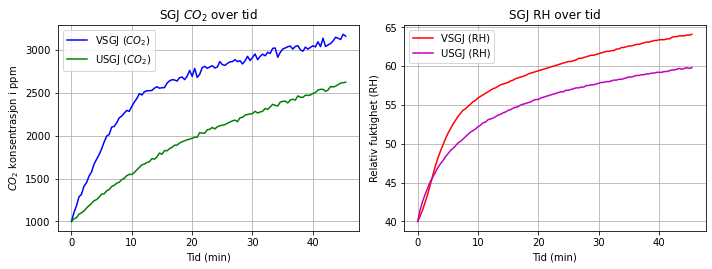

In [17]:
time = [float(t)*0.417 for t in range(0,len(co2_usgj))]

# CO_2 målinger 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_xlabel("Tid (min)")
ax1.set_ylabel("$CO_2$ konsentrasjon i ppm")
ax1.plot(time, co2_vsgj, label = "VSGJ ($CO_2$)", color = "b")
ax1.plot(time, co2_usgj, label = "USGJ ($CO_2$)", color = "g")
ax1.set_title('SGJ $CO_2$ over tid')

# RH målinger 
ax2.set_xlabel("Tid (min)")
ax2.set_ylabel("Relativ fuktighet (RH)")
ax2.plot(time, rh_vsgj, label = "VSGJ (RH)", color = "r")
ax2.plot(time, rh_usgj, label = "USGJ (RH)", color = "m")
ax2.set_title('SGJ RH over tid')

# Spesifikasjoner 
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
ax1.grid(), ax2.grid()
ax1.legend(), ax2.legend()
plt.show()

fig.savefig("Image/fig1.png",dpi = 300)

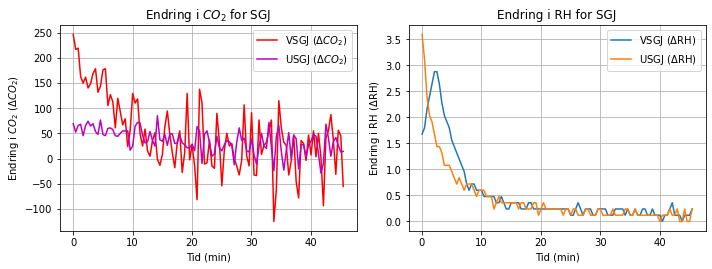

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_xlabel("Tid (min)")
ax1.set_ylabel("Endring i $CO_2$ ($\Delta CO_2$)")
ax1.set_title("Endring i $CO_2$ for SGJ")
ax1.plot(time,np.gradient(co2_vsgj, time), label = "VSGJ ($\Delta CO_2$)", color = "r")
ax1.plot(time,np.gradient(co2_usgj, time), label = "USGJ ($\Delta CO_2$)", color = "m")

ax2.set_title("Endring i RH for SGJ")
ax2.set_xlabel("Tid (min)")
ax2.set_ylabel("Endring i RH ($\Delta$RH)")
ax2.plot(time, np.gradient(rh_vsgj, time), label = "VSGJ ($\Delta$RH)")
ax2.plot(time, np.gradient(rh_usgj, time), label = "USGJ ($\Delta$RH)")

ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
fig.savefig("Image/fig2.png", dpi = 300)

### Resultater for MGJ (Mindre God Jord)

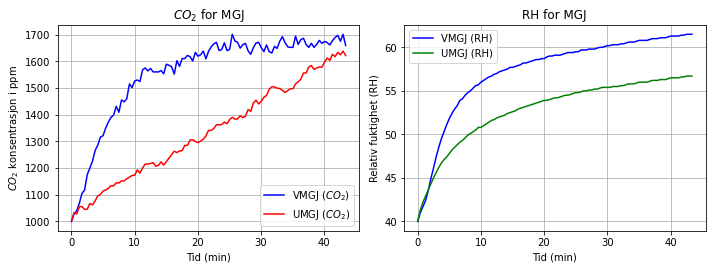

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
time = [float(t)*0.417 for t in range(0,len(co2_vmgj))]

ax1.set_xlabel("Tid (min)")
ax1.set_ylabel("$CO_2$ konsentrasjon i ppm")
ax1.set_title("$CO_2$ for MGJ")
ax1.plot(time[:-3], co2_vmgj[:-3], label = "VMGJ ($CO_2$)", color = "b")
ax1.plot(time[:-3], co2_umgj, label = "UMGJ ($CO_2$)", color = "r")
#ax.plot(time1, co2_umgj, label = "UMGJ ($CO_2$)", color = "g")


ax2.set_xlabel("Tid (min)")
ax2.set_ylabel("Relativ fuktighet (RH)")
ax2.set_title("RH for MGJ")
ax2.plot(time[:-3], rh_vmgj[:-3], label = "VMGJ (RH)", color = "b")
ax2.plot(time[:-3], rh_umgj, label = "UMGJ (RH)", color = "g")


ax1.grid(), ax2.grid()
ax1.legend() , ax2.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
fig.savefig("Image/fig3.png", dpi = 300)

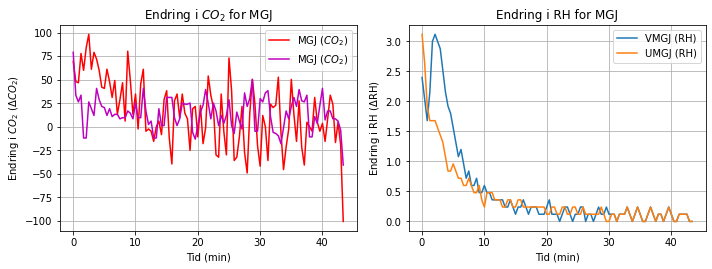

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_title("Endring i $CO_2$ for MGJ")
ax1.set_xlabel("Tid (min)")
ax1.set_ylabel("Endring i $CO_2$ ($\Delta CO_2$)")
ax1.plot(time[:-3], np.gradient(co2_vmgj[:-3], time[:-3]), label = "MGJ ($CO_2$)", color = "r")
ax1.plot(time[:-3], np.gradient(co2_umgj, time[:-3]), label = "MGJ ($CO_2$)", color = "m")

ax2.set_title("Endring i RH for MGJ")
ax2.set_xlabel("Tid (min)")
ax2.set_ylabel("Endring i RH ($\Delta$RH)")
ax2.plot(time[:-3], np.gradient(rh_vmgj[:-3], time[:-3]), label = "VMGJ (RH)")
ax2.plot(time[:-3], np.gradient(rh_umgj, time[:-3]), label = "UMGJ (RH)")

ax1.grid() , ax2.grid()
ax1.legend() , ax2.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
fig.savefig("Image/fig4.png", dpi = 300)

### Kombinerte figurer

110 110


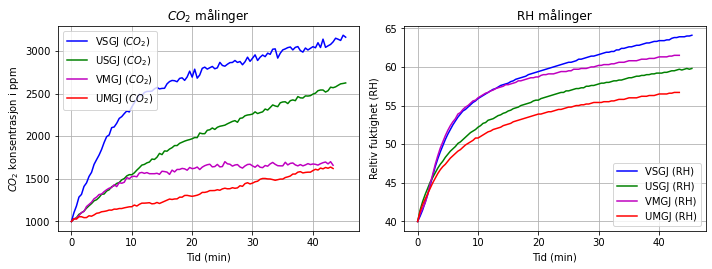

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
time = [float(t)*0.417 for t in range(0,len(co2_vsgj))]
temp_usgj = [float(x) for x in temp_usgj]
temp_vsgj = [float(x) for x in temp_vsgj]

print(len(co2_usgj), len(time))
ax1.set_xlabel("Tid (min)")
ax1.set_ylabel("$CO_2$ konsentrasjon i ppm")
ax1.set_title("$CO_2$ målinger")
ax1.plot(time, co2_vsgj, label = "VSGJ ($CO_2$)", color = "b")
ax1.plot(time, co2_usgj, label = "USGJ ($CO_2$)", color = "g")
ax1.plot(time[:-5], co2_vmgj[:-3], label = "VMGJ ($CO_2$)", color = "m")
ax1.plot(time[:-5],co2_umgj, label = "UMGJ ($CO_2$)" , color = "r" )

ax2.set_xlabel("Tid (min)")
ax2.set_ylabel("Reltiv fuktighet (RH)")
ax2.set_title("RH målinger")
ax2.plot(time, rh_vsgj, label = "VSGJ (RH)", color = "b")
ax2.plot(time, rh_usgj, label = "USGJ (RH)", color = "g")
ax2.plot(time[:-5], rh_vmgj[:-3], label = "VMGJ (RH)", color = "m")
ax2.plot(time[:-5], rh_umgj, label = "UMGJ (RH)" , color = "r" )

ax1.grid() , ax2.grid()
fig.tight_layout()
ax1.legend(), ax2.legend()
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()
fig.savefig("Image/fig5.png", dpi=300)

### Interessante sammenhenger 

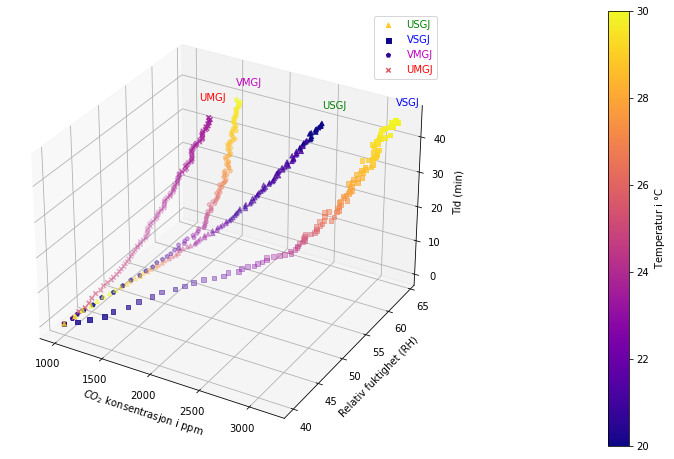

In [22]:

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(co2_usgj, rh_usgj,time,c=temp_usgj, cmap="plasma", marker = "^", label = "USGJ")
#ax.plot(co2_usgj, rh_usgj,time,label = "USGJ", c = "g")
ax.text(co2_usgj[-1], rh_usgj[-1], time[-1]+4, "USGJ", c = "g")


ax.scatter(co2_vsgj, rh_vsgj,time, c=temp_vsgj, cmap="plasma", marker = "s", label = "VSGJ")
#ax.plot(co2_vsgj, rh_vsgj,time, label = "VSGJ", c = "b")
ax.text(co2_vsgj[-1], rh_vsgj[-1], time[-1]+4, "VSGJ", c = "b")

temp_vmgj = [float(x) for x in temp_vmgj]
ax.scatter(co2_vmgj[:-3], rh_vmgj[:-3],time[:-5], c=temp_vmgj[:-3], cmap="plasma", marker = "p", label = "VMGJ")
#ax.plot(co2_vmgj[:-3], rh_vmgj[:-3],time[:-5], label = "VMGJ", c = "m")
ax.text(co2_vmgj[:-3][-1], rh_vmgj[:-3][-1], time[:-5][-1]+4, "VMGJ", c = "m")

temp_umgj = [float(x) for x in temp_umgj]
sc = ax.scatter(co2_umgj, rh_umgj,time[:-5], c=temp_umgj, cmap="plasma", marker = "x", label = "UMGJ")
#ax.plot(co2_umgj, rh_umgj,time[:-5], label = "UMGJ", c = "r")
ax.text(co2_umgj[-1]-100, rh_umgj[-1], time[:-5][-1]+4, "UMGJ", c = "r")

t = [20 + 0.1*x for x in range(0,10) ]
sc.set_clim(20,30)
cbar = plt.colorbar(sc)
cbar.set_label("Temperatur i $\degree$C")
ax.set_xlabel("$CO_2$ konsentrasjon i ppm")
ax.set_ylabel("Relativ fuktighet (RH)")
ax.set_zlabel("Tid (min)")

colors = ["g","b","m","r"]

l = plt.legend()
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
    
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
fig.subplots_adjust(left=-1.4) 
plt.show()

fig.savefig("Image/Samlet_målinger.jpg", dpi = 600)

### Interesante målinger 

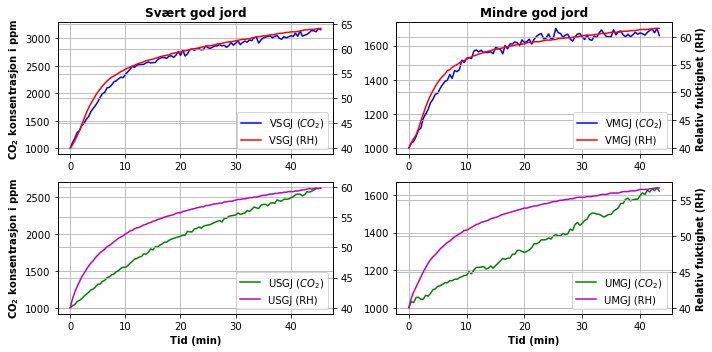

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))
time = [t*0.417 for t in range(0,len(co2_usgj))]

# SVÆRT GOD JORD (VARME)
ax1.set_ylabel("$\mathbf{CO_2}$ konsentrasjon i ppm", fontweight='bold')
ax1.set_title("Svært god jord", fontweight='bold')
graph1 = ax1.plot(time, co2_vsgj, label = "VSGJ ($CO_2$)", color = "b")

ax1s=ax1.twinx()
graph2 = ax1s.plot(time,rh_vsgj, label = "VSGJ (RH)", color = "r")

graphs = graph1 + graph2
labels = [graph.get_label() for graph in graphs]
plt.legend(graphs, labels)


# MINDRE GOD JORD (VARME)
ax2.set_title("Mindre god jord", fontweight='bold')
graph1 = ax2.plot(time[:-5], co2_vmgj[:-3], label = "VMGJ ($CO_2$)", color = "b")

ax2s=ax2.twinx()
ax2s.set_ylabel("Relativ fuktighet (RH)", fontweight='bold')
graph2 = ax2s.plot(time[:-5],rh_vmgj[:-3], label = "VMGJ (RH)", color = "r")

graphs = graph1 + graph2
labels = [graph.get_label() for graph in graphs]
plt.legend(graphs, labels)

# SVÆRT GOD JORD (UTE)
ax3.set_xlabel("Tid (min)", fontweight='bold')
ax3.set_ylabel("$\mathbf{CO_2}$ konsentrasjon i ppm", fontweight='bold')
graph1 = ax3.plot(time, co2_usgj, label = "USGJ ($CO_2$)", color = "g")

ax3s=ax3.twinx()
graph2 = ax3s.plot(time,rh_usgj, label = "USGJ (RH)", color = "m")
graphs = graph1 + graph2
labels = [graph.get_label() for graph in graphs]
plt.legend(graphs, labels)

# MINDRE GOD JORD (UTE)
ax4.set_xlabel("Tid (min)", fontweight='bold')
graph1 = ax4.plot(time[:-5], co2_umgj, label = "UMGJ ($CO_2$)", color = "g")

ax4s=ax4.twinx()
ax4s.set_ylabel("Relativ fuktighet (RH)", fontweight='bold')
graph2 = ax4s.plot(time[:-5],rh_umgj, label = "UMGJ (RH)", color = "m")

graphs = graph1 + graph2
labels = [graph.get_label() for graph in graphs]
plt.legend(graphs, labels)

ax1.grid(), ax1s.grid()
ax2.grid(), ax2s.grid()
ax3.grid(), ax3s.grid()
ax4.grid(), ax4s.grid()

fig.tight_layout()
plt.show()

fig.savefig("Image/fig6.png", dpi = 300)

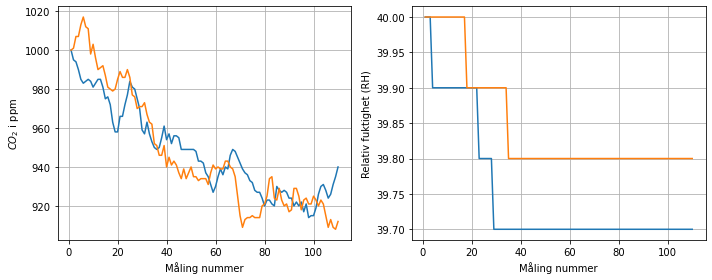

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
data1 = pd.read_csv("data/kalib_sensor1.csv", delimiter = ";")
data2 = pd.read_csv("data/kalib_sensor2.csv", delimiter = ";")

co2_1 = list(data1["co2"].values)
co2_2 = list(data2["co2"].values)

rh_1 = list(data1["rh"].values)
rh_2 = list(data2["rh"].values)

co2_1 = [(1000-co2_1[0]) + x for x in co2_1]
co2_2 = [(1000-co2_2[0]) + x for x in co2_2]

rh_1 = [(40-rh_1[0]) + x for x in rh_1]
rh_2 = [(40-rh_2[0]) + x for x in rh_2]
x_val = [x for x in range(1,len(co2_1)+1)]

ax1.plot(x_val, co2_2), ax1.plot(x_val, co2_1)
ax2.plot(x_val, rh_2), ax2.plot(x_val, rh_1)
ax1.set_ylabel("$CO_2$ i ppm"), ax1.set_xlabel("Måling nummer")
ax2.set_ylabel("Relativ fuktighet (RH)"), ax2.set_xlabel("Måling nummer")
ax1.grid(),  ax2.grid()
fig.tight_layout()
plt.show()
fig.savefig("Image/kalibreringsdata.png", dpi = 300)